In [1]:
# Check if GPU is available
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-04-30 20:20:54.375957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 20:20:55.065071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2024-04-30 20:20:55.664320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 20:20:55.699899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 20:20:55.700115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
%load_ext tensorboard

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, RandomContrast, RandomFlip, RandomRotation, RandomBrightness, RandomTranslation
from pathlib import Path
import matplotlib.pyplot as plt
import pydot
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
import keras_tuner as kt

In [4]:
# Main data dir
train_data_dir = Path('train/').with_suffix('')
test_data_dir = Path('test/').with_suffix('')

# Parameters
batch_size = 32
image_size = (150, 150)
num_classes = 15
epochs = 20

In [5]:
plant_labels = [
    "Ulmus carpinifolia",
    "Acer",
    "Salix aurita",
    "Quercus",
    "Alnus incana",
    "Betula pubescens",
    "Salix alba 'Sericea'",
    "Populus tremula",
    "Ulmus glabra",
    "Sorbus aucuparia",
    "Salix sinerea",
    "Populus",
    "Tilia",
    "Sorbus intermedia",
    "Fagus silvatica"
]
plant_labels = sorted(plant_labels)
print(plant_labels)

['Acer', 'Alnus incana', 'Betula pubescens', 'Fagus silvatica', 'Populus', 'Populus tremula', 'Quercus', "Salix alba 'Sericea'", 'Salix aurita', 'Salix sinerea', 'Sorbus aucuparia', 'Sorbus intermedia', 'Tilia', 'Ulmus carpinifolia', 'Ulmus glabra']


In [6]:
# Data loading and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255, # rescale data
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)  # 20% validation split

# Load and preprocess data
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
    )

validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
    )

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

Found 720 images belonging to 15 classes.
Found 180 images belonging to 15 classes.
Found 225 images belonging to 15 classes.


In [7]:
inv_map_train = {v: k for k, v in train_generator.class_indices.items()}
inv_map_test = {v: k for k, v in test_generator.class_indices.items()}

In [8]:
# Augment Data

data_augmentation = tf.keras.Sequential([
  RandomRotation(0.3),
  RandomContrast(0.3)
])

2024-04-30 20:20:56.317219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 20:20:56.317610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 20:20:56.317896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:

# Model creation
def create_model(hp):
    # Units for dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    model = Sequential()
    model.add(data_augmentation)
    # Number of layers for the CNN
    for i in range(1, hp.Int("num_layers", 2, 6)):
        # Number of filters in Conv2D layers
        model.add(Conv2D(hp.Int(f"filters_{i}", 32, 128, step=32), (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Learning rates
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [11]:
tuner = kt.Hyperband(
                     create_model,
                     objective='val_loss',
                     max_epochs=epochs,
                     factor=3,
                     directory='runs',
                     project_name='leaf_class'
                    )

tuner_bo = kt.BayesianOptimization(
                     create_model,
                     objective='val_loss',
                     directory='runs_bo',
                     project_name='leaf_class'
                    )

tuner_rs = kt.RandomSearch(
                     create_model,
                     objective='val_loss',
                     directory='runs_rs',
                     project_name='leaf_class'
                    )

Reloading Tuner from runs/leaf_class/tuner0.json
Reloading Tuner from runs_bo/leaf_class/tuner0.json
Reloading Tuner from runs_rs/leaf_class/tuner0.json


In [12]:
tuner.search(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[stop_early])

In [13]:
tuner_rs.search(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[stop_early])

In [14]:
tuner_bo.search(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[stop_early])

In [15]:
best_hps=tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search using Hyperband tuner is complete. The optimal number of layers is {best_hps.get('num_layers')}. The optimal number of units in the densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of layers is 4. The optimal number of units in the densely-connected
layer is 512 and the optimal learning rate for the optimizer is 0.001.



In [16]:
best_hps_rs=tuner_rs.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search using Random Search tuner is complete. The optimal number of layers is {best_hps_rs.get('num_layers')}. The optimal number of units in the densely-connected
layer is {best_hps_rs.get('units')} and the optimal learning rate for the optimizer is {best_hps_rs.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of layers is 3. The optimal number of units in the densely-connected
layer is 224 and the optimal learning rate for the optimizer is 0.001.



In [17]:
best_hps_bo=tuner_bo.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search using Bayesian Optimization tuner is complete. The optimal number of layers is {best_hps_bo.get('num_layers')}. The optimal number of units in the densely-connected
layer is {best_hps_bo.get('units')} and the optimal learning rate for the optimizer is {best_hps_bo.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of layers is 6. The optimal number of units in the densely-connected
layer is 192 and the optimal learning rate for the optimizer is 0.001.



In [18]:
model = tuner.hypermodel.build(best_hps)
# model.save('hypermodel_1.keras')

/home/lucypher/Desktop/forestry/.venv/lib64/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model_rs = tuner_rs.hypermodel.build(best_hps_rs)
# model_rs.save('hypermodel_2.keras')

In [20]:
model_bo = tuner_bo.hypermodel.build(best_hps_bo)
# model_bo.save('hypermodel_3.keras')

In [21]:
# model = tf.keras.models.load_model('hypermodel_1.keras')
# model_rs = tf.keras.models.load_model('hypermodel_2.keras')
# model_bo = tf.keras.models.load_model('hypermodel_3.keras')

In [22]:
# Train to find best epoch

history = model.fit(train_generator,epochs=50, validation_data=validation_generator)
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

Epoch 1/50


/home/lucypher/Desktop/forestry/.venv/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-30 20:21:00.482164: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8901


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.0863 - loss: 2.7397 - val_accuracy: 0.2611 - val_loss: 2.2476
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.2849 - loss: 2.1044 - val_accuracy: 0.4222 - val_loss: 1.6817
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.4624 - loss: 1.5026 - val_accuracy: 0.5889 - val_loss: 1.2032
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.5655 - loss: 1.2843 - val_accuracy: 0.6667 - val_loss: 1.0559
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 0.6561 - loss: 1.1034 - val_accuracy: 0.5389 - val_loss: 1.2588
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.6715 - loss: 0.9737 - val_accuracy: 0.7222 - val_loss: 0.8662
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.6637 - loss: 1.0118 - val_accuracy: 0.6889 - val_loss: 0.9155
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.7033 - loss: 0.9505 - val_accuracy: 0.7056 - val

In [23]:
history_rs = model_rs.fit(train_generator,epochs=50, validation_data=validation_generator)
val_loss_per_epoch_rs = history_rs.history['val_loss']
best_epoch_rs = val_loss_per_epoch_rs.index(min(val_loss_per_epoch_rs)) + 1
print(f'Best epoch: {best_epoch_rs}')

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.0918 - loss: 9.0773 - val_accuracy: 0.3111 - val_loss: 2.2661
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.2840 - loss: 2.2223 - val_accuracy: 0.4222 - val_loss: 1.5744
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.4773 - loss: 1.5294 - val_accuracy: 0.5778 - val_loss: 1.2043
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 0.5695 - loss: 1.2863 - val_accuracy: 0.5444 - val_loss: 1.5581
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.5997 - loss: 1.2350 - val_accuracy: 0.6389 - val_loss: 0.9783
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.7257 - loss: 0.8500 - val_accuracy: 0.5944 - val_loss: 1.1061
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.6975 - loss: 0.8935 - val_accuracy: 0.6833 - val_loss: 0.8599
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.6962 - loss: 0.8667 - val_accuracy: 0

In [24]:
history_bo = model_bo.fit(train_generator,epochs=50, validation_data=validation_generator)
val_loss_per_epoch_bo = history_bo.history['val_loss']
best_epoch_bo = val_loss_per_epoch_bo.index(min(val_loss_per_epoch_bo)) + 1
print(f'Best epoch: {best_epoch_bo}')

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.0436 - loss: 2.7122 - val_accuracy: 0.1167 - val_loss: 2.6685
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.1112 - loss: 2.5932 - val_accuracy: 0.2833 - val_loss: 2.0825
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.2546 - loss: 2.0774 - val_accuracy: 0.3944 - val_loss: 1.7432
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.3590 - loss: 1.8354 - val_accuracy: 0.4500 - val_loss: 1.5421
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.4648 - loss: 1.4827 - val_accuracy: 0.4389 - val_loss: 1.4967
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.4623 - loss: 1.3530 - val_accuracy: 0.4889 - val_loss: 1.3578
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.5522 - loss: 1.2492 - val_accuracy: 0.5611 - val_loss: 1.2130
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.5288 - loss: 1.3176 - val_accuracy: 0

In [25]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel_rs = tuner_rs.hypermodel.build(best_hps_rs)
hypermodel_bo = tuner_bo.hypermodel.build(best_hps_bo)



In [26]:
# Retrain the models
history = hypermodel.fit(train_generator, epochs=best_epoch, validation_data=validation_generator)

Epoch 1/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.0926 - loss: 2.7478 - val_accuracy: 0.2167 - val_loss: 2.1234
Epoch 2/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.3538 - loss: 1.9435 - val_accuracy: 0.4167 - val_loss: 1.5946
Epoch 3/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 0.5091 - loss: 1.3931 - val_accuracy: 0.5389 - val_loss: 1.2638
Epoch 4/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.5606 - loss: 1.2575 - val_accuracy: 0.5556 - val_loss: 1.2485
Epoch 5/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.6256 - loss: 1.1515 - val_accuracy: 0.6667 - val_loss: 1.0030
Epoch 6/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.6629 - loss: 0.9656 - val_accuracy: 0.6556 - val_loss: 0.9193
Epoch 7/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.6986 - loss: 0.8838 - val_accuracy: 0.7222 - val_loss: 0.8887
Epoch 8/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.7230 - loss: 0.8514 - val_accuracy: 0.

In [27]:
history_rs = hypermodel_rs.fit(train_generator, epochs=best_epoch_rs, validation_data=validation_generator)

Epoch 1/41
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.0704 - loss: 8.5483 - val_accuracy: 0.1833 - val_loss: 2.4690
Epoch 2/41
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.2399 - loss: 2.3318 - val_accuracy: 0.5167 - val_loss: 1.5524
Epoch 3/41
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.4365 - loss: 1.6173 - val_accuracy: 0.5278 - val_loss: 1.4147
Epoch 4/41
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.6097 - loss: 1.2505 - val_accuracy: 0.5500 - val_loss: 1.4790
Epoch 5/41
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.6355 - loss: 1.1239 - val_accuracy: 0.6333 - val_loss: 1.1431
Epoch 6/41
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.6391 - loss: 1.1543 - val_accuracy: 0.6500 - val_loss: 0.9510
Epoch 7/41
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.6485 - loss: 1.0085 - val_accuracy: 0.6944 - val_loss: 0.9300
Epoch 8/41
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.7424 - loss: 0.8032 - val_accuracy: 0.

In [28]:
history_bo = hypermodel_bo.fit(train_generator, epochs=best_epoch_bo, validation_data=validation_generator)

Epoch 1/49
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.0669 - loss: 2.6787 - val_accuracy: 0.1333 - val_loss: 2.5051
Epoch 2/49
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.2462 - loss: 2.1557 - val_accuracy: 0.3278 - val_loss: 1.8500
Epoch 3/49
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.2749 - loss: 1.9386 - val_accuracy: 0.3389 - val_loss: 1.7666
Epoch 4/49
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.3995 - loss: 1.5990 - val_accuracy: 0.4889 - val_loss: 1.4115
Epoch 5/49
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.4776 - loss: 1.3962 - val_accuracy: 0.4667 - val_loss: 1.3825
Epoch 6/49
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.5013 - loss: 1.3607 - val_accuracy: 0.5500 - val_loss: 1.2315
Epoch 7/49
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.5735 - loss: 1.2497 - val_accuracy: 0.6056 - val_loss: 1.1053
Epoch 8/49
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.5762 - loss: 1.1950 - val_accuracy: 0.

In [29]:
hypermodel.summary()
hypermodel_rs.summary()
hypermodel_bo.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 148, 148, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 74, 74, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 72, 72, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 34, 34, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,735,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,459,087 (55.16 MB)

 Trainable params: 4,819,695 (18.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,639,392 (36.77 MB)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 165888)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 224)            │    37,159,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 15)             │         3,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,714,479 (426.16 MB)

 Trainable params: 37,238,159 (142.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 74,476,320 (284.10 MB)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 148, 148, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 72, 72, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 34, 34, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 5, 5, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15)             │         2,895 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,391 (1.84 MB)

 Trainable params: 160,463 (626.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,928 (1.22 MB)

In [30]:
hypermodel.save('hypermodel_basic.keras')
hypermodel_rs.save('hypermodel_rs.keras')
hypermodel_bo.save('hypermodel_bo.keras')

In [31]:
# dot_img_file = 'hypermodel.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [32]:
%matplotlib inline

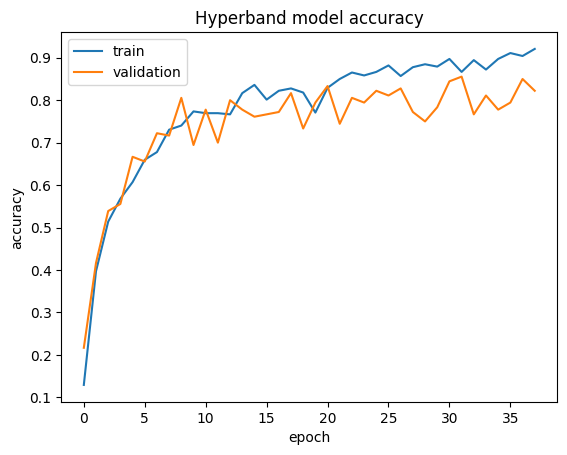

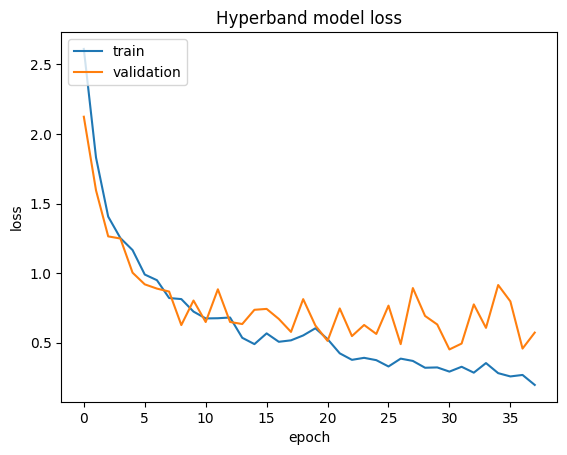

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Hyperband model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Hyperband model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

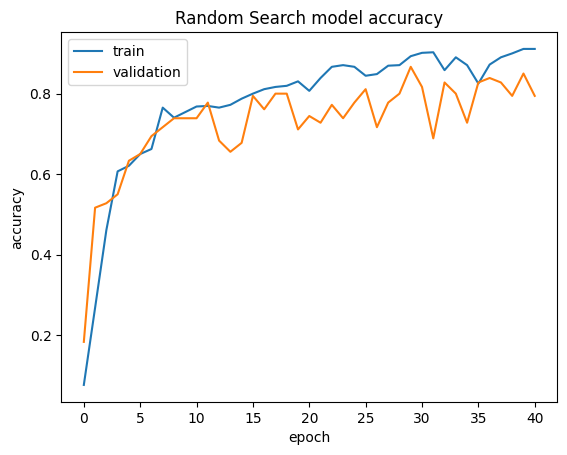

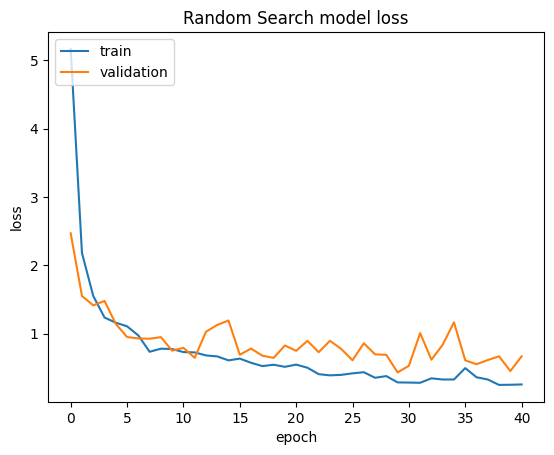

In [34]:
plt.plot(history_rs.history['accuracy'])
plt.plot(history_rs.history['val_accuracy'])
plt.title('Random Search model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_rs.history['loss'])
plt.plot(history_rs.history['val_loss'])
plt.title('Random Search model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

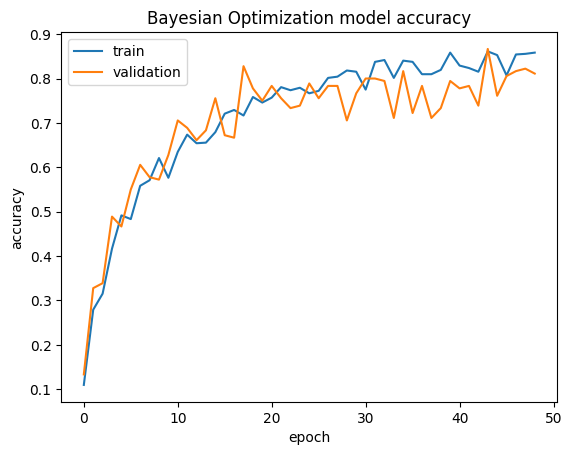

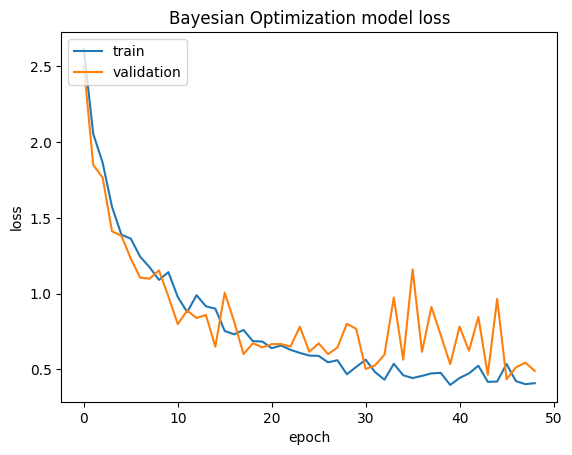

In [35]:
plt.plot(history_bo.history['accuracy'])
plt.plot(history_bo.history['val_accuracy'])
plt.title('Bayesian Optimization model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bo.history['loss'])
plt.plot(history_bo.history['val_loss'])
plt.title('Bayesian Optimization model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [36]:
test_history = hypermodel.evaluate(test_generator, verbose=2)
test_history_rs = hypermodel_rs.evaluate(test_generator, verbose=2)
test_history_bo = hypermodel_bo.evaluate(test_generator, verbose=2)

8/8 - 3s - 395ms/step - accuracy: 0.8133 - loss: 0.5763
8/8 - 2s - 211ms/step - accuracy: 0.8444 - loss: 0.5858
8/8 - 2s - 231ms/step - accuracy: 0.8222 - loss: 0.5651


In [38]:
print(f"For model with Hyperband tuning, testing loss is {test_history[0]} and accuracy is {test_history[1]*100}%")
print(f"For model with Random Search tuning, testing loss is {test_history_rs[0]} and accuracy is {test_history_rs[1]*100}%")
print(f"For model with Bayesian Optimization tuning, testing loss is {test_history_bo[0]} and accuracy is {test_history_bo[1]*100}%")

For model with Hyperband tuning, testing loss is 0.576286256313324 and accuracy is 81.33333325386047%
For model with Random Search tuning, testing loss is 0.5858224034309387 and accuracy is 84.44444537162781%
For model with Bayesian Optimization tuning, testing loss is 0.5651025772094727 and accuracy is 82.22222328186035%
